# First model

Classifies image into [0...10]

In [26]:
#custom neural networks
import neural_networks as ann
#other imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import torch.optim as optim
import matplotlib.pyplot as plt

In [17]:
batch_size_train = 64
batch_size_test = 1000


train_loader = DataLoader(MNIST('mnist_data/', train=True, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = DataLoader(MNIST('mnist_data/', train=False, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

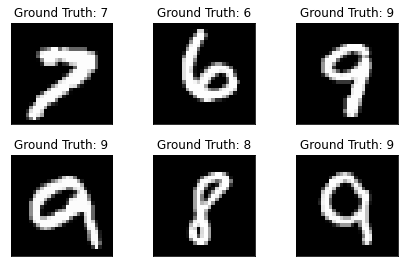

In [18]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [19]:
#PARAMETERS
n_epochs = 3
learning_rate = 0.01
momentum = 0.5

conv_net = ann.ConvNet()
optimizer = optim.Adam(conv_net.parameters(), lr=learning_rate)

In [20]:
for epoch in range(1, n_epochs + 1):
    ann.train(epoch,train_loader,conv_net,optimizer)
    ann.test(test_loader,conv_net)


Test set: Avg. loss: 0.1188, Accuracy: 9643/10000 (96%)



Test set: Avg. loss: 0.1099, Accuracy: 9652/10000 (97%)



Test set: Avg. loss: 0.1159, Accuracy: 9672/10000 (97%)


/home/leitao/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1354: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


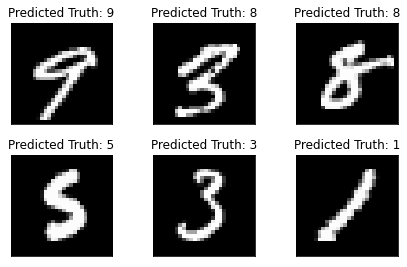

In [23]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].view(28, 28), cmap='gray', interpolation='none')
    predicted_class = torch.argmax(conv_net(example_data[i]), dim=1).item()
    plt.title("Predicted Truth: {}".format(predicted_class))
    plt.xticks([])
    plt.yticks([])

# Second Model

Takes the pretrained model and adds one last layer to make it a binary classification

#### Load the MNIST data as binary classification instead of multiclass

In [24]:
# Specify the target digit for binary classification
target_digit = 8
# Define transformations
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

#### Add extra layer

In [27]:
extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
for epoch in range(1, n_epochs + 1):
    ann.train(epoch,binary_train_loader,model,optimizer)
    ann.test(binary_test_loader,model)


Test set: Avg. loss: 0.0172, Accuracy: 9940/10000 (99%)



Test set: Avg. loss: 0.0193, Accuracy: 9933/10000 (99%)



Test set: Avg. loss: 0.0152, Accuracy: 9945/10000 (99%)


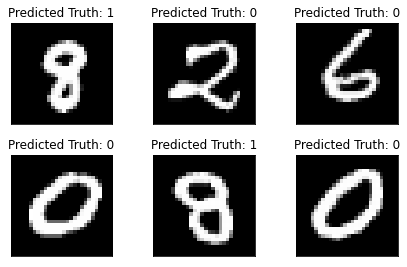

In [30]:
examples = enumerate(binary_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
first_eight = (example_targets==1).nonzero()[0]

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    i += first_eight.item()
    plt.tight_layout()
    plt.imshow(example_data[i].view(28, 28), cmap='gray', interpolation='none')
    predicted_class = torch.argmax(model(example_data[i]), dim=1).item()
    plt.title("Predicted Truth: {}".format(predicted_class))
    plt.xticks([])
    plt.yticks([])

# Autoencoder

Will be used for Croco

In [31]:
autoencoder = ann.Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [33]:
for epoch in range(1, 31):
    ann.train_encoder(epoch,train_loader,autoencoder,optimizer)
    ann.test_encoder(test_loader,autoencoder)


Test set: Avg. loss: 399.8980



Test set: Avg. loss: 397.1669



Test set: Avg. loss: 396.4535



Test set: Avg. loss: 396.1745



Test set: Avg. loss: 394.9951



Test set: Avg. loss: 395.0214



Test set: Avg. loss: 393.9991



Test set: Avg. loss: 393.9782



Test set: Avg. loss: 393.4004



Test set: Avg. loss: 393.5355



Test set: Avg. loss: 394.5476



Test set: Avg. loss: 393.3214



Test set: Avg. loss: 393.2293



Test set: Avg. loss: 392.9021



Test set: Avg. loss: 392.8848



Test set: Avg. loss: 392.9417



Test set: Avg. loss: 392.2601



Test set: Avg. loss: 393.7251



Test set: Avg. loss: 391.6137



Test set: Avg. loss: 391.7693



Test set: Avg. loss: 392.0814



Test set: Avg. loss: 391.4256



Test set: Avg. loss: 392.4624



Test set: Avg. loss: 390.8270



Test set: Avg. loss: 390.7251



Test set: Avg. loss: 390.4470



Test set: Avg. loss: 391.1663



Test set: Avg. loss: 390.2818



Test set: Avg. loss: 390.1166



Test set: Avg. loss: 390.3436


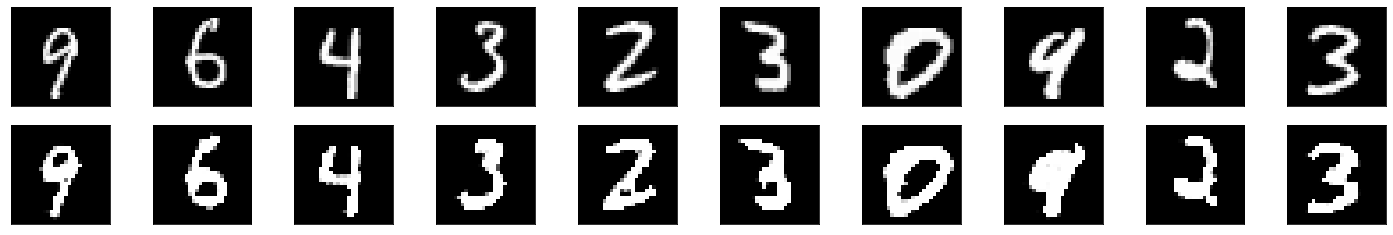

In [34]:
examples = enumerate(binary_test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# plot the first ten input images and then reconstructed images
fig = plt.figure(figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(example_data[i].view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(autoencoder(example_data[i]).detach().view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

# Save all the models

In [35]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model_checkpoint.pth')
torch.save(autoencoder.state_dict(), 'autoencoder_checkpoint.pth')